In [7]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

In [9]:
# Transaction sales data (1% population sample)
sales = pd.read_csv(
    "system2_case_study_transaction_data_monthly_sales_by_locationid.csv",
    parse_dates=["period_start", "period_end"]
)

# Store open / close dates (transaction location IDs)
location_info = pd.read_csv(
    "system2_case_study_transaction_data_location_info.csv",
    parse_dates=["est_open_date", "est_close_date"]
)

# Reported comparable sales through Q3-2022
reported = pd.read_excel(
    "system2_case_study_reported_numbers.xlsx"
)

# Web-scraped store location data (used for closure analysis)
web_locations = pd.read_csv(
    "system2_case_study_webscrape_data_locations.csv"
)

In [10]:
location_info.head(5)

,locationid,est_open_date,est_close_date
0,1,2017-01-01,2024-09-01
1,16,2017-01-01,2024-09-01
2,17,2017-01-01,2021-08-01
3,18,2021-05-01,2022-12-01
4,2,2017-01-01,2024-09-01


In [11]:
len(web_locations)

747

In [12]:
web_locations.head(5)

,address,as_of_date,city,phone,state,location_id,store_services,title,url,zipcode,postcode,latitude,longitude
0,13477 Middlebelt Road,2024-10-07,Livonia,(734) 666-3019,Michigan,539,In-Store Shopping | In-Store Pickup | Curbside...,Livonia Commons,https://stores.partycity.com/us/mi/livonia/par...,48150,48150,42.381156,-83.335770
1,5114 28th Street SE,2024-10-07,Grand Rapids,(616) 365-5419,Michigan,4107,In-Store Shopping | In-Store Pickup | Curbside...,Waterfall Shoppes,https://stores.partycity.com/us/mi/grandrapids...,49512,49512,42.910841,-85.540782
2,2677 Oak Valley Dr,2024-10-07,Ann Arbor,(734) 519-5591,Michigan,4111,In-Store Shopping | In-Store Pickup | Curbside...,Oak Valley Plaza,https://stores.partycity.com/us/mi/annarbor/pa...,48103,48103,42.247490,-83.768959
3,3000 White Bear Avenue North,2024-10-07,Maplewood,(612) 428-0697,Minnesota,1138,In-Store Shopping | In-Store Pickup | Curbside...,Plaza 3000 Shopping Center,https://stores.partycity.com/us/mn/maplewood/p...,55109,55109,45.032238,-93.014647
4,2560 Lemay Ferry Road,2024-10-07,Saint Louis,(314) 396-2245,Missouri,5163,In-Store Shopping | In-Store Pickup | Curbside...,Lemay Plaza,https://stores.partycity.com/us/mo/saintlouis/...,63125,63125,38.518385,-90.305049


In [13]:
sales

,symbol,locationid,period_start,period_end,label,amount
0,NYSE:PRTY,1,2019-08-01,2019-08-31,2019-MS08,2128.213469
1,NYSE:PRTY,16,2019-08-01,2019-08-31,2019-MS08,676.387327
2,NYSE:PRTY,17,2019-08-01,2019-08-31,2019-MS08,770.193862
3,NYSE:PRTY,2,2019-08-01,2019-08-31,2019-MS08,2269.441296
4,NYSE:PRTY,21,2019-08-01,2019-08-31,2019-MS08,265.600689
...,...,...,...,...,...,...
38862,NYSE:PRTY,994,2023-12-01,2023-12-31,2023-MS12,987.590765
38863,NYSE:PRTY,995,2023-12-01,2023-12-31,2023-MS12,556.119912
38864,NYSE:PRTY,996,2023-12-01,2023-12-31,2023-MS12,692.716506
38865,NYSE:PRTY,997,2023-12-01,2023-12-31,2023-MS12,1011.097667


In [14]:
web_locations['state'].value_counts()

state
California        88
Texas             82
Florida           63
New York          49
Illinois          39
Georgia           27
New Jersey        26
Pennsylvania      26
Ohio              24
Michigan          21
North Carolina    21
Virginia          21
Massachusetts     20
Maryland          20
Indiana           17
Washington        16
Tennessee         16
Missouri          15
Arizona           15
Colorado          13
Wisconsin         11
Connecticut       11
Alabama           10
South Carolina    10
Minnesota         10
Kentucky           8
Louisiana          7
Oklahoma           7
Nevada             6
Iowa               6
Puerto Rico        5
Arkansas           4
North Dakota       4
Kansas             4
New Mexico         3
Mississippi        3
New Hampshire      3
Nebraska           3
Delaware           2
Maine              2
Oregon             2
Rhode Island       2
Hawaii             2
West Virginia      1
Vermont            1
Alaska             1
Name: count, dtype: int64

In [15]:
metro_centers = {
    "New York": (40.7128, -74.0060),
    "Los Angeles": (34.0522, -118.2437),
    "Chicago": (41.8781, -87.6298),
    "Houston": (29.7604, -95.3698),
    "Dallas": (32.7767, -96.7970),
    "Atlanta": (33.7490, -84.3880),
    "Miami": (25.7617, -80.1918),
    "Washington DC": (38.9072, -77.0369),
    "Boston": (42.3601, -71.0589),
    "San Francisco": (37.7749, -122.4194),
    "Seattle": (47.6062, -122.3321),
    "Phoenix": (33.4484, -112.0740),
    "Denver": (39.7392, -104.9903),
    "Detroit": (42.3314, -83.0458),
    "Minneapolis": (44.9778, -93.2650),
}

In [16]:
# Haversine function to compute distance in mile
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [17]:
# Using Metrocenters find the distance from the store
def distance_to_nearest_metro(row):
    distances = [haversine(row["latitude"], row["longitude"], lat, lon)
                 for lat, lon in metro_centers.values()]
    return min(distances)

web_locations["distance_to_nearest_metro_miles"] = web_locations.apply(
    distance_to_nearest_metro, axis=1
)

In [18]:
web_locations.head(5)

,address,as_of_date,city,phone,state,location_id,store_services,title,url,zipcode,postcode,latitude,longitude,distance_to_nearest_metro_miles
0,13477 Middlebelt Road,2024-10-07,Livonia,(734) 666-3019,Michigan,539,In-Store Shopping | In-Store Pickup | Curbside...,Livonia Commons,https://stores.partycity.com/us/mi/livonia/par...,48150,48150,42.381156,-83.335770,15.199326
1,5114 28th Street SE,2024-10-07,Grand Rapids,(616) 365-5419,Michigan,4107,In-Store Shopping | In-Store Pickup | Curbside...,Waterfall Shoppes,https://stores.partycity.com/us/mi/grandrapids...,49512,49512,42.910841,-85.540782,128.269379
2,2677 Oak Valley Dr,2024-10-07,Ann Arbor,(734) 519-5591,Michigan,4111,In-Store Shopping | In-Store Pickup | Curbside...,Oak Valley Plaza,https://stores.partycity.com/us/mi/annarbor/pa...,48103,48103,42.247490,-83.768959,37.414426
3,3000 White Bear Avenue North,2024-10-07,Maplewood,(612) 428-0697,Minnesota,1138,In-Store Shopping | In-Store Pickup | Curbside...,Plaza 3000 Shopping Center,https://stores.partycity.com/us/mn/maplewood/p...,55109,55109,45.032238,-93.014647,12.795709
4,2560 Lemay Ferry Road,2024-10-07,Saint Louis,(314) 396-2245,Missouri,5163,In-Store Shopping | In-Store Pickup | Curbside...,Lemay Plaza,https://stores.partycity.com/us/mo/saintlouis/...,63125,63125,38.518385,-90.305049,271.664409


In [19]:
# Classify location type
def classify_location(lat, lon, cities=metro_centers):
    min_distance = min([geodesic((lat, lon), city_loc).miles for city_loc in cities.values()])
    if min_distance <= 5:
        return "Urban"
    elif min_distance <= 20:
        return "Suburban"
    else:
        return "Rural"

web_locations["location_type"] = web_locations.apply(
    lambda row: classify_location(row["latitude"], row["longitude"]), axis=1
)


In [20]:
web_locations['location_type'].value_counts()

location_type
Rural       580
Suburban    156
Urban        11
Name: count, dtype: int64

In [21]:
web_locations.head(5)

,address,as_of_date,city,phone,state,location_id,store_services,title,url,zipcode,postcode,latitude,longitude,distance_to_nearest_metro_miles,location_type
0,13477 Middlebelt Road,2024-10-07,Livonia,(734) 666-3019,Michigan,539,In-Store Shopping | In-Store Pickup | Curbside...,Livonia Commons,https://stores.partycity.com/us/mi/livonia/par...,48150,48150,42.381156,-83.335770,15.199326,Suburban
1,5114 28th Street SE,2024-10-07,Grand Rapids,(616) 365-5419,Michigan,4107,In-Store Shopping | In-Store Pickup | Curbside...,Waterfall Shoppes,https://stores.partycity.com/us/mi/grandrapids...,49512,49512,42.910841,-85.540782,128.269379,Rural
2,2677 Oak Valley Dr,2024-10-07,Ann Arbor,(734) 519-5591,Michigan,4111,In-Store Shopping | In-Store Pickup | Curbside...,Oak Valley Plaza,https://stores.partycity.com/us/mi/annarbor/pa...,48103,48103,42.247490,-83.768959,37.414426,Rural
3,3000 White Bear Avenue North,2024-10-07,Maplewood,(612) 428-0697,Minnesota,1138,In-Store Shopping | In-Store Pickup | Curbside...,Plaza 3000 Shopping Center,https://stores.partycity.com/us/mn/maplewood/p...,55109,55109,45.032238,-93.014647,12.795709,Suburban
4,2560 Lemay Ferry Road,2024-10-07,Saint Louis,(314) 396-2245,Missouri,5163,In-Store Shopping | In-Store Pickup | Curbside...,Lemay Plaza,https://stores.partycity.com/us/mo/saintlouis/...,63125,63125,38.518385,-90.305049,271.664409,Rural


In [22]:
# Number of services offered per store
web_locations["num_services"] = (
    web_locations["store_services"]
    .fillna("")
    .str.count("\|") + 1
)
\
# Flag urban vs suburban (rough heuristic via ZIP length)
#web_locations["suburban_flag"] = (
#    web_locations["zipcode"].astype(str).str.len() == 5
#)


In [23]:
web_locations.head(5)

,address,as_of_date,city,phone,state,location_id,store_services,title,url,zipcode,postcode,latitude,longitude,distance_to_nearest_metro_miles,location_type,num_services
0,13477 Middlebelt Road,2024-10-07,Livonia,(734) 666-3019,Michigan,539,In-Store Shopping | In-Store Pickup | Curbside...,Livonia Commons,https://stores.partycity.com/us/mi/livonia/par...,48150,48150,42.381156,-83.335770,15.199326,Suburban,6
1,5114 28th Street SE,2024-10-07,Grand Rapids,(616) 365-5419,Michigan,4107,In-Store Shopping | In-Store Pickup | Curbside...,Waterfall Shoppes,https://stores.partycity.com/us/mi/grandrapids...,49512,49512,42.910841,-85.540782,128.269379,Rural,6
2,2677 Oak Valley Dr,2024-10-07,Ann Arbor,(734) 519-5591,Michigan,4111,In-Store Shopping | In-Store Pickup | Curbside...,Oak Valley Plaza,https://stores.partycity.com/us/mi/annarbor/pa...,48103,48103,42.247490,-83.768959,37.414426,Rural,6
3,3000 White Bear Avenue North,2024-10-07,Maplewood,(612) 428-0697,Minnesota,1138,In-Store Shopping | In-Store Pickup | Curbside...,Plaza 3000 Shopping Center,https://stores.partycity.com/us/mn/maplewood/p...,55109,55109,45.032238,-93.014647,12.795709,Suburban,6
4,2560 Lemay Ferry Road,2024-10-07,Saint Louis,(314) 396-2245,Missouri,5163,In-Store Shopping | In-Store Pickup | Curbside...,Lemay Plaza,https://stores.partycity.com/us/mo/saintlouis/...,63125,63125,38.518385,-90.305049,271.664409,Rural,6


In [24]:
web_locations["location_risk"] = web_locations["location_type"].map({"Urban": 0, "Suburban": 1, "Rural": 1})
web_locations["services_risk"] = (web_locations["num_services"] <= 3).astype(int)

In [25]:
# Combine into a total closure risk score
web_locations["closure_risk_score"] = web_locations["location_risk"] + web_locations["services_risk"]

In [26]:
# Higher score = higher closure risk
high_risk_stores = web_locations.sort_values(
    "closure_risk_score",
    ascending=False
)

high_risk_stores.head()

,address,as_of_date,city,phone,state,location_id,store_services,title,url,zipcode,postcode,latitude,longitude,distance_to_nearest_metro_miles,location_type,num_services,location_risk,services_risk,closure_risk_score
328,128 Bailey Farm Road,2024-10-07,Monroe,(845) 655-7015,New York,686,In-Store Shopping | Helium,Harriman Commons,https://stores.partycity.com/us/ny/monroe/part...,10950,10950,41.317219,-74.153342,42.462315,Rural,2,1,1,2
185,"RD #2, Bldg #2-828",2024-10-07,"Bldg #2-828, Mayaguez",(787) 831-5121,Puerto Rico,138,In-Store Shopping | In-Store Pickup | Helium,Villa Capitán Bldg. II,https://stores.partycity.com/us/pr/mayaguez/pa...,680,680,18.200345,-67.117951,986.244212,Rural,3,1,1,2
607,KM 11.7 Barrio Canovanillas,2024-10-07,Carolina,(787) 257-5770,Puerto Rico,167,In-Store Shopping | In-Store Pickup | Helium,Los Colobos Shopping Center,https://stores.partycity.com/us/pr/carolina/pa...,985,985,18.354609,-65.924441,1046.088588,Rural,3,1,1,2
608,3373 Steelyard Drive,2024-10-07,Cleveland,(216) 238-4369,Ohio,926,In-Store Shopping,Steelyard Commons,https://stores.partycity.com/us/oh/cleveland/p...,44109,44109,41.461418,-81.688162,92.131680,Rural,1,1,1,2
255,4410 Wyoming Boulevard NE,2024-10-07,Albuquerque,(505) 847-3858,New Mexico,942,In-Store Shopping | Helium,Montgomery Crossing Shopping Center,https://stores.partycity.com/us/nm/albuquerque...,87111,87111,35.129863,-106.550139,329.758914,Rural,2,1,1,2


In [27]:
high_risk_stores['closure_risk_score'].value_counts()

closure_risk_score
1    690
2     46
0     11
Name: count, dtype: int64

In [28]:
# Flag high-risk stores
high_risk_stores["high_risk_flag"] = web_locations["closure_risk_score"] == 2

# Count stores
store_counts = high_risk_stores["high_risk_flag"].value_counts().rename(
    index={True: "High Risk", False: "Not High Risk"}
)

store_counts

high_risk_flag
Not High Risk    701
High Risk         46
Name: count, dtype: int64

In [29]:
store_share = (
    high_risk_stores["high_risk_flag"]
    .value_counts(normalize=True)
    .rename(index={True: "High Risk", False: "Not High Risk"})
    * 100
)

store_share

high_risk_flag
Not High Risk    93.842035
High Risk         6.157965
Name: proportion, dtype: float64

closure_risk_score   0    1   2
location_type                  
Rural                0  537  43
Suburban             0  153   3
Urban               11    0   0


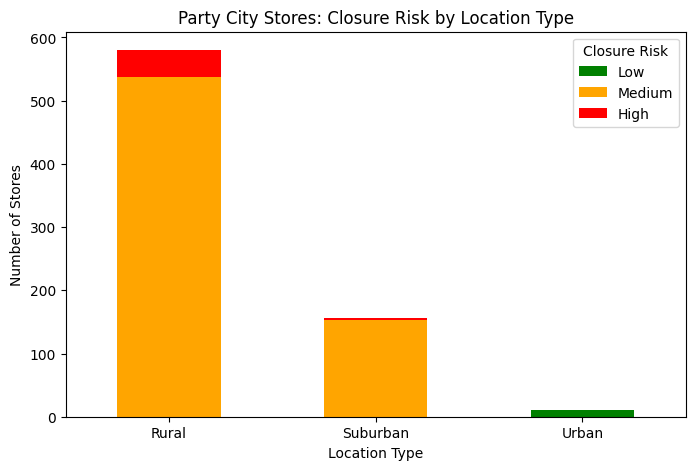

In [72]:
import matplotlib.pyplot as plt
# Make sure location_type exists
web_locations['location_type'].value_counts()  # should show Urban, Suburban, Rural

# Group by location type and closure risk
risk_by_location = web_locations.groupby(['location_type','closure_risk_score']).size().unstack(fill_value=0)
print(risk_by_location)

risk_colors = ['green','orange','red']  # 0,1,2

risk_by_location.plot(kind='bar', stacked=True, color=risk_colors, figsize=(8,5))

plt.title("Party City Stores: Closure Risk by Location Type")
plt.xlabel("Location Type")
plt.ylabel("Number of Stores")
plt.legend(title="Closure Risk", labels=['Low','Medium','High'])
plt.xticks(rotation=0)
plt.savefig("Party City Stores_Closure Risk by Location Type.png", dpi=300, bbox_inches="tight")
plt.show()

In [31]:
high_risk_stores = pd.merge(high_risk_stores,location_info, left_on='location_id', right_on='locationid', how='left')

In [32]:
high_risk_stores

,address,as_of_date,city,phone,state,location_id,store_services,title,url,zipcode,...,distance_to_nearest_metro_miles,location_type,num_services,location_risk,services_risk,closure_risk_score,high_risk_flag,locationid,est_open_date,est_close_date
0,128 Bailey Farm Road,2024-10-07,Monroe,(845) 655-7015,New York,686,In-Store Shopping | Helium,Harriman Commons,https://stores.partycity.com/us/ny/monroe/part...,10950,...,42.462315,Rural,2,1,1,2,True,686.0,2017-05-01,2024-09-01
1,"RD #2, Bldg #2-828",2024-10-07,"Bldg #2-828, Mayaguez",(787) 831-5121,Puerto Rico,138,In-Store Shopping | In-Store Pickup | Helium,Villa Capitán Bldg. II,https://stores.partycity.com/us/pr/mayaguez/pa...,680,...,986.244212,Rural,3,1,1,2,True,NaN,NaT,NaT
2,KM 11.7 Barrio Canovanillas,2024-10-07,Carolina,(787) 257-5770,Puerto Rico,167,In-Store Shopping | In-Store Pickup | Helium,Los Colobos Shopping Center,https://stores.partycity.com/us/pr/carolina/pa...,985,...,1046.088588,Rural,3,1,1,2,True,NaN,NaT,NaT
3,3373 Steelyard Drive,2024-10-07,Cleveland,(216) 238-4369,Ohio,926,In-Store Shopping,Steelyard Commons,https://stores.partycity.com/us/oh/cleveland/p...,44109,...,92.131680,Rural,1,1,1,2,True,926.0,2017-01-01,2024-09-01
4,4410 Wyoming Boulevard NE,2024-10-07,Albuquerque,(505) 847-3858,New Mexico,942,In-Store Shopping | Helium,Montgomery Crossing Shopping Center,https://stores.partycity.com/us/nm/albuquerque...,87111,...,329.758914,Rural,2,1,1,2,True,942.0,2017-01-01,2024-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,3149 Kennedy Boulevard,2024-10-07,North Bergen,(201) 381-5766,New Jersey,711,In-Store Shopping | In-Store Pickup | Schedule...,Columbia Park Shopping Center,https://stores.partycity.com/us/nj/northbergen...,7047,...,4.550485,Urban,5,0,0,0,False,711.0,2018-08-01,2024-09-01
758,3225 Southwest Freeway,2024-10-07,Houston,(713) 292-9839,Texas,578,In-Store Shopping | In-Store Pickup | Curbside...,Summit Square Shopping Center,https://stores.partycity.com/us/tx/houston/par...,77027,...,4.194525,Urban,6,0,0,0,False,578.0,2017-01-01,2024-09-01
759,1514 West 33rd Street,2024-10-07,Chicago,(708) 831-3328,Illinois,664,In-Store Shopping | In-Store Pickup | Curbside...,River's Edge Shopping Center,https://stores.partycity.com/us/il/chicago/par...,60608,...,3.458215,Urban,6,0,0,0,False,664.0,2018-08-01,2024-09-01
760,733 State Highway 440,2024-10-07,Jersey City,(201) 984-4034,New Jersey,406,In-Store Shopping | In-Store Pickup | Curbside...,Hudson Mall,https://stores.partycity.com/us/nj/jerseycity/...,7304,...,4.609664,Urban,6,0,0,0,False,406.0,2018-08-01,2024-09-01


In [33]:
merged = pd.merge(
    high_risk_stores,
    sales,
    left_on='location_id',
    right_on='locationid',
    how='left')

In [34]:
merged.columns

Index(['address', 'as_of_date', 'city', 'phone', 'state', 'location_id',
       'store_services', 'title', 'url', 'zipcode', 'postcode', 'latitude',
       'longitude', 'distance_to_nearest_metro_miles', 'location_type',
       'num_services', 'location_risk', 'services_risk', 'closure_risk_score',
       'high_risk_flag', 'locationid_x', 'est_open_date', 'est_close_date',
       'symbol', 'locationid_y', 'period_start', 'period_end', 'label',
       'amount'],
      dtype='object')

In [35]:
merged = merged[
    (merged['period_start'] >= merged['est_open_date']) &
    (merged['period_start'] <= merged['est_close_date'])
]

In [36]:
len(merged)

32794

In [37]:
# Extract year from sales
merged['year'] = merged['period_start'].dt.year

# Aggregate total sales per store per year
yearly_sales = (
    merged.groupby(['location_id', 'title', 'year'])
          .agg({'amount':'sum', 'closure_risk_score':'max',
                'est_open_date':'first','est_close_date':'first'})
          .reset_index()
)

In [38]:
yearly_sales['closure_risk_score'].value_counts()

closure_risk_score
1    2918
2     163
0      55
Name: count, dtype: int64

In [39]:
yearly_sales.head(5)

,location_id,title,year,amount,closure_risk_score,est_open_date,est_close_date
0,3,Route 10,2019,163024.016062,1,2017-01-01,2022-07-01
1,3,Route 10,2020,210314.967817,1,2017-01-01,2022-07-01
2,3,Route 10,2021,227107.363111,1,2017-01-01,2022-07-01
3,3,Route 10,2022,118614.950544,1,2017-01-01,2022-07-01
4,3,Route 10,2023,71553.567382,1,2017-04-01,2024-09-01


In [40]:
today = pd.Timestamp.today()

yearly_sales['status'] = yearly_sales['est_close_date'].apply(
    lambda x: 'Open' if x >= today else 'Closed'
)

In [41]:
yearly_sales['status'].value_counts()

status
Closed    3136
Name: count, dtype: int64

In [42]:
yearly_sales = yearly_sales.sort_values(['location_id','year'])

In [43]:
# Absolute change
yearly_sales['sales_change'] = yearly_sales.groupby('location_id')['amount'].diff()

# Percentage change
yearly_sales['sales_pct_change'] = yearly_sales.groupby('location_id')['amount'].pct_change() * 100

In [44]:
yearly_sales

,location_id,title,year,amount,closure_risk_score,est_open_date,est_close_date,status,sales_change,sales_pct_change
0,3,Route 10,2019,163024.016062,1,2017-01-01,2022-07-01,Closed,NaN,NaN
1,3,Route 10,2020,210314.967817,1,2017-01-01,2022-07-01,Closed,47290.951755,29.008580
2,3,Route 10,2021,227107.363111,1,2017-01-01,2022-07-01,Closed,16792.395294,7.984403
3,3,Route 10,2022,118614.950544,1,2017-01-01,2022-07-01,Closed,-108492.412567,-47.771420
4,3,Route 10,2023,71553.567382,1,2017-04-01,2024-09-01,Closed,-47061.383162,-39.675760
...,...,...,...,...,...,...,...,...,...,...
3131,6071,Buckland Hills Plaza,2019,2598.396011,1,2017-03-01,2024-09-01,Closed,NaN,NaN
3132,6071,Buckland Hills Plaza,2020,7694.723380,1,2017-03-01,2024-09-01,Closed,5096.327370,196.133590
3133,6071,Buckland Hills Plaza,2021,6375.438220,1,2017-03-01,2024-09-01,Closed,-1319.285161,-17.145323
3134,6071,Buckland Hills Plaza,2022,15578.581432,1,2017-03-01,2024-09-01,Closed,9203.143213,144.353108


In [45]:
yearly_sales['trend'] = yearly_sales['sales_change'].apply(
    lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No change')
)

In [46]:
yearly_sales

,location_id,title,year,amount,closure_risk_score,est_open_date,est_close_date,status,sales_change,sales_pct_change,trend
0,3,Route 10,2019,163024.016062,1,2017-01-01,2022-07-01,Closed,NaN,NaN,No change
1,3,Route 10,2020,210314.967817,1,2017-01-01,2022-07-01,Closed,47290.951755,29.008580,Increase
2,3,Route 10,2021,227107.363111,1,2017-01-01,2022-07-01,Closed,16792.395294,7.984403,Increase
3,3,Route 10,2022,118614.950544,1,2017-01-01,2022-07-01,Closed,-108492.412567,-47.771420,Decrease
4,3,Route 10,2023,71553.567382,1,2017-04-01,2024-09-01,Closed,-47061.383162,-39.675760,Decrease
...,...,...,...,...,...,...,...,...,...,...,...
3131,6071,Buckland Hills Plaza,2019,2598.396011,1,2017-03-01,2024-09-01,Closed,NaN,NaN,No change
3132,6071,Buckland Hills Plaza,2020,7694.723380,1,2017-03-01,2024-09-01,Closed,5096.327370,196.133590,Increase
3133,6071,Buckland Hills Plaza,2021,6375.438220,1,2017-03-01,2024-09-01,Closed,-1319.285161,-17.145323,Decrease
3134,6071,Buckland Hills Plaza,2022,15578.581432,1,2017-03-01,2024-09-01,Closed,9203.143213,144.353108,Increase


In [47]:
yearly_sales['closure_risk_score'].value_counts()

closure_risk_score
1    2918
2     163
0      55
Name: count, dtype: int64

In [48]:

# Predict likely closure

# Simple heuristic: high closure risk + declining sales = likely closure
yearly_sales['likely_close_flag'] = np.where(
    (yearly_sales['closure_risk_score'] >= 2) & (yearly_sales['trend'] == 'Decrease'),
    True,
    False
)

# rank risk by closure
yearly_sales['closure_risk_rank'] = yearly_sales.groupby('year')['closure_risk_score'].rank(method='dense', ascending=False)

# Final columns
final_cols = [
    'location_id','title','year','amount','status',
    'sales_change','sales_pct_change','trend',
    'closure_risk_score','likely_close_flag','closure_risk_rank'
]
yearly_sales_final = yearly_sales[final_cols]

# View final output
yearly_sales_final.head(20)

,location_id,title,year,amount,status,sales_change,sales_pct_change,trend,closure_risk_score,likely_close_flag,closure_risk_rank
0,3,Route 10,2019,163024.016062,Closed,NaN,NaN,No change,1,False,2.0
1,3,Route 10,2020,210314.967817,Closed,47290.951755,29.008580,Increase,1,False,2.0
2,3,Route 10,2021,227107.363111,Closed,16792.395294,7.984403,Increase,1,False,2.0
3,3,Route 10,2022,118614.950544,Closed,-108492.412567,-47.771420,Decrease,1,False,2.0
4,3,Route 10,2023,71553.567382,Closed,-47061.383162,-39.675760,Decrease,1,False,2.0
5,4,Brentwood Plaza Shopping Center,2019,33944.342671,Closed,NaN,NaN,No change,1,False,2.0
6,4,Brentwood Plaza Shopping Center,2020,59450.374044,Closed,25506.031373,75.140743,Increase,1,False,2.0
7,4,Brentwood Plaza Shopping Center,2021,96269.692530,Closed,36819.318486,61.932863,Increase,1,False,2.0
8,4,Brentwood Plaza Shopping Center,2022,62378.696365,Closed,-33890.996164,-35.204222,Decrease,1,False,2.0
9,4,Brentwood Plaza Shopping Center,2023,46428.794948,Closed,-15949.901418,-25.569469,Decrease,1,False,2.0


In [49]:
high_risk_stores.columns

Index(['address', 'as_of_date', 'city', 'phone', 'state', 'location_id',
       'store_services', 'title', 'url', 'zipcode', 'postcode', 'latitude',
       'longitude', 'distance_to_nearest_metro_miles', 'location_type',
       'num_services', 'location_risk', 'services_risk', 'closure_risk_score',
       'high_risk_flag', 'locationid', 'est_open_date', 'est_close_date'],
      dtype='object')

In [50]:
yearly_sales_final.columns

Index(['location_id', 'title', 'year', 'amount', 'status', 'sales_change',
       'sales_pct_change', 'trend', 'closure_risk_score', 'likely_close_flag',
       'closure_risk_rank'],
      dtype='object')

In [51]:
# Select the relevant columns from high_risk_stores
risk_info = high_risk_stores[['location_id','num_services','location_type','high_risk_flag']].drop_duplicates('location_id')

# Merge with your yearly_sales_final
yearly_sales_final = yearly_sales_final.merge(
    risk_info,
    on='location_id',
    how='left'
)

# Optional: reorder columns for clarity
final_cols = [
    'location_id','title','year','amount','status','sales_change','sales_pct_change','trend',
    'closure_risk_score','num_services','location_type','high_risk_flag','likely_close_flag','closure_risk_rank'
]

yearly_sales_final = yearly_sales_final[final_cols]

# View final result
yearly_sales_final.head(20)

,location_id,title,year,amount,status,sales_change,sales_pct_change,trend,closure_risk_score,num_services,location_type,high_risk_flag,likely_close_flag,closure_risk_rank
0,3,Route 10,2019,163024.016062,Closed,NaN,NaN,No change,1,6,Suburban,False,False,2.0
1,3,Route 10,2020,210314.967817,Closed,47290.951755,29.008580,Increase,1,6,Suburban,False,False,2.0
2,3,Route 10,2021,227107.363111,Closed,16792.395294,7.984403,Increase,1,6,Suburban,False,False,2.0
3,3,Route 10,2022,118614.950544,Closed,-108492.412567,-47.771420,Decrease,1,6,Suburban,False,False,2.0
4,3,Route 10,2023,71553.567382,Closed,-47061.383162,-39.675760,Decrease,1,6,Suburban,False,False,2.0
5,4,Brentwood Plaza Shopping Center,2019,33944.342671,Closed,NaN,NaN,No change,1,7,Rural,False,False,2.0
6,4,Brentwood Plaza Shopping Center,2020,59450.374044,Closed,25506.031373,75.140743,Increase,1,7,Rural,False,False,2.0
7,4,Brentwood Plaza Shopping Center,2021,96269.692530,Closed,36819.318486,61.932863,Increase,1,7,Rural,False,False,2.0
8,4,Brentwood Plaza Shopping Center,2022,62378.696365,Closed,-33890.996164,-35.204222,Decrease,1,7,Rural,False,False,2.0
9,4,Brentwood Plaza Shopping Center,2023,46428.794948,Closed,-15949.901418,-25.569469,Decrease,1,7,Rural,False,False,2.0


In [52]:
yearly_sales_final['likely_close_flag'].value_counts()

likely_close_flag
False    3092
True       44
Name: count, dtype: int64

In [53]:
def generate_closure_reason(row):
    reasons = []

    # Risk score drivers
    if row['num_services'] <= 2:
        reasons.append("Limited in-store services")
    elif row['num_services'] == 3:
        reasons.append("Moderate service offering")

    # Location type
    if row['location_type'] == "Suburban":
        reasons.append("Suburban location")
    elif row['location_type'] == "Rural":
        reasons.append("Rural location")  # optional if you want to highlight rural stores

    # Sales performance
    if row['trend'] == 'Decrease':
        reasons.append("Declining sales trend")
    elif row['trend'] == 'Increase':
        reasons.append("Sales growth offsetting risk")

    # Final logic
    if row['likely_close_flag']:
        return " | ".join(reasons)
    else:
        return "Stable performance despite risk factors"

In [54]:
yearly_sales_final['closure_reason'] = yearly_sales_final.apply(
    generate_closure_reason,
    axis=1
)

In [55]:
final_cols = [
    'location_id','title','year','amount',
    'sales_pct_change','trend',
    'closure_risk_score','num_services','location_type',
    'likely_close_flag','closure_risk_rank',
    'closure_reason'
]

In [56]:
yearly_sales_final = yearly_sales_final[final_cols]

In [57]:
likely_to_close = yearly_sales_final[
    yearly_sales_final['likely_close_flag'] == True
]

In [58]:
pd.set_option('display.max_colwidth', None)

In [59]:
likely_to_close

,location_id,title,year,amount,sales_pct_change,trend,closure_risk_score,num_services,location_type,likely_close_flag,closure_risk_rank,closure_reason
39,24,San Pedro Square,2023,7666.893711,-41.152823,Decrease,2,2,Rural,True,1.0,Limited in-store services | Rural location | Declining sales trend
103,118,Waikele Center,2022,187493.319576,-44.516813,Decrease,2,1,Rural,True,1.0,Limited in-store services | Rural location | Declining sales trend
104,118,Waikele Center,2023,90764.750027,-51.590409,Decrease,2,1,Rural,True,1.0,Limited in-store services | Rural location | Declining sales trend
106,125,North Regency Square,2020,1453.295086,-25.247963,Decrease,2,2,Rural,True,1.0,Limited in-store services | Rural location | Declining sales trend
148,164,Oceangate Commerce Center,2022,14145.151919,-13.311568,Decrease,2,2,Suburban,True,1.0,Limited in-store services | Suburban location | Declining sales trend
176,175,Deerbrook Marketplace,2021,22107.247229,-3.593606,Decrease,2,3,Suburban,True,1.0,Moderate service offering | Suburban location | Declining sales trend
178,175,Deerbrook Marketplace,2023,22294.505612,-30.895247,Decrease,2,3,Suburban,True,1.0,Moderate service offering | Suburban location | Declining sales trend
190,187,Ventura Blvd,2020,23901.498853,-11.040106,Decrease,2,2,Suburban,True,1.0,Limited in-store services | Suburban location | Declining sales trend
193,187,Ventura Blvd,2023,46641.600650,-13.739440,Decrease,2,2,Suburban,True,1.0,Limited in-store services | Suburban location | Declining sales trend
212,197,Danada Square West Mall,2022,13503.316803,-41.315544,Decrease,2,2,Rural,True,1.0,Limited in-store services | Rural location | Declining sales trend


In [60]:
latest_year = (
    yearly_sales_final
    .sort_values('year')
    .groupby('location_id')
    .tail(1)
)

In [61]:
latest_year.describe()

,location_id,year,amount,sales_pct_change,closure_risk_score,num_services,closure_risk_rank
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,1629.922468,2022.992089,23212.440896,0.650134,1.036392,5.821203,1.963608
std,1889.340043,0.088664,29213.794257,50.952309,0.264554,1.041756,0.264554
min,3.000000,2022.000000,470.913205,-89.211062,0.000000,1.000000,1.000000
25%,512.500000,2023.000000,10219.949199,-24.686634,1.000000,6.000000,2.000000
50%,839.500000,2023.000000,16837.220499,-4.422483,1.000000,6.000000,2.000000
75%,1175.250000,2023.000000,28276.385311,14.809121,1.000000,6.000000,2.000000
max,6071.000000,2023.000000,516095.177231,663.855796,2.000000,8.000000,3.000000


In [62]:
risk_by_location

closure_risk_score,0,1,2
location_type,,,
Rural,0,537,43
Suburban,0,153,3
Urban,11,0,0


In [64]:
import seaborn as sns

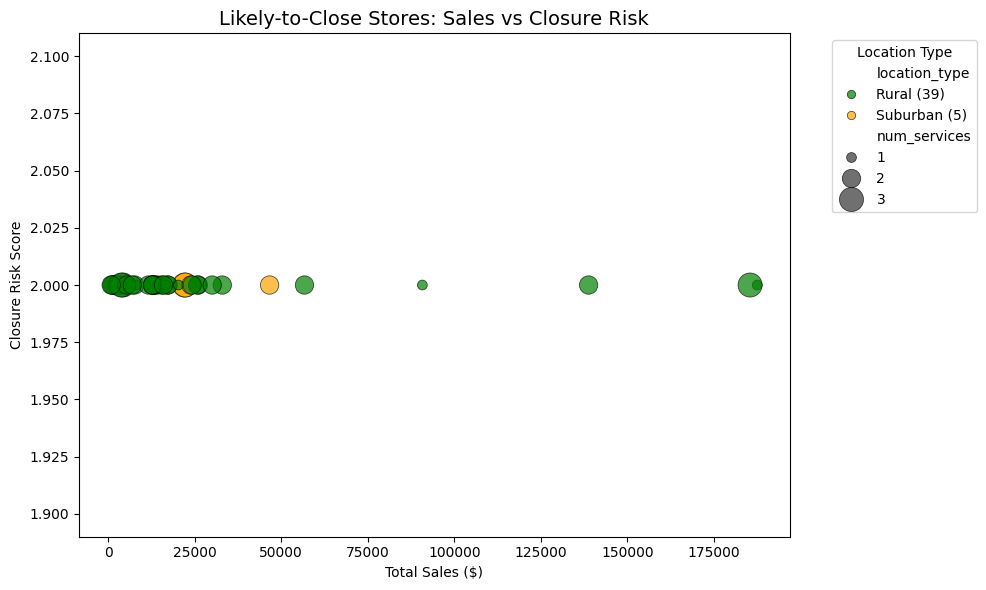

In [65]:
# Filter only likely-to-close stores if desired
data = yearly_sales_final[yearly_sales_final['likely_close_flag']]

# Count stores per location_type
counts = data['location_type'].value_counts()

# Create a mapping for legend labels
legend_labels = {loc: f"{loc} ({counts[loc]})" for loc in counts.index}

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=data,
    x='amount',
    y='closure_risk_score',
    hue='location_type',
    size='num_services',
    palette={'Urban':'blue','Suburban':'orange','Rural':'green'},
    sizes=(50,300),
    alpha=0.7,
    edgecolor='black'
)

plt.title("Likely-to-Close Stores: Sales vs Closure Risk", fontsize=14)
plt.xlabel("Total Sales ($)")
plt.ylabel("Closure Risk Score")

# Update legend labels
handles, labels = plt.gca().get_legend_handles_labels()
# Only modify hue labels (skip size legend)
new_labels = [legend_labels.get(l, l) for l in labels]
plt.legend(handles=handles, labels=new_labels, title="Location Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

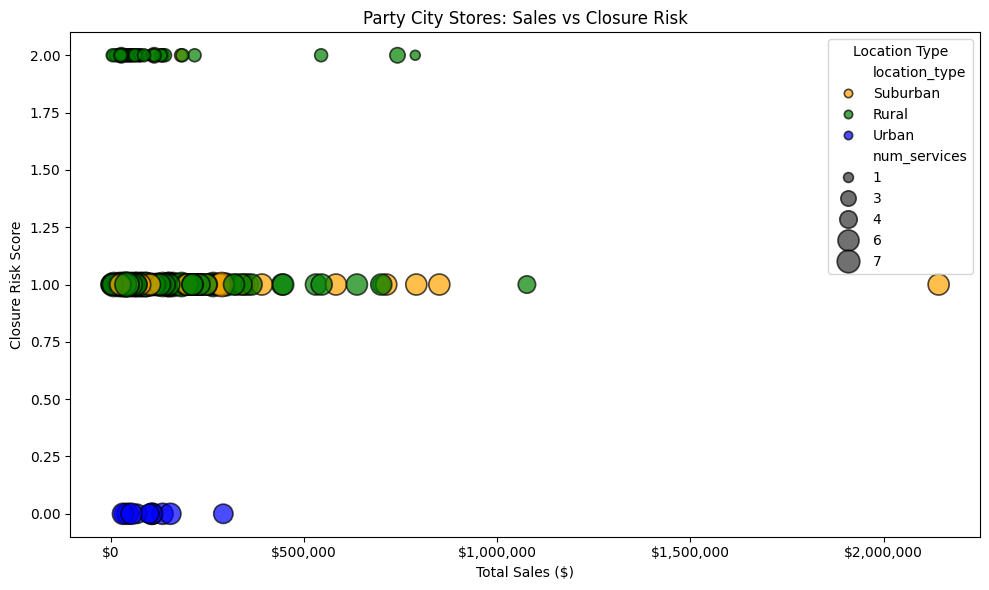

In [73]:
import matplotlib.ticker as mtick

# Sum sales per store if you want total
sales_summary = yearly_sales_final.groupby(['location_id','title','closure_risk_score','num_services','location_type'])['amount'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=sales_summary,
    x='amount',
    y='closure_risk_score',
    size='num_services',
    hue='location_type',
    palette={'Urban':'blue','Suburban':'orange','Rural':'green'},
    sizes=(50,300),
    alpha=0.7,
    edgecolor='black'
)
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.xlabel("Total Sales ($)")
plt.ylabel("Closure Risk Score")
plt.title("Party City Stores: Sales vs Closure Risk")
plt.legend(title="Location Type")
plt.tight_layout()
plt.savefig("Party City Stores Sales vs Closure Risk.png", dpi=300, bbox_inches="tight")
plt.show()

In [67]:
likely_to_close_pdf = likely_to_close[['location_id','title','closure_reason']]

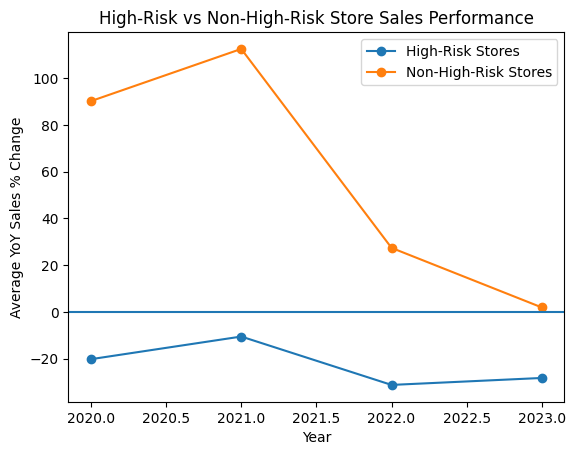

In [74]:
import matplotlib.pyplot as plt

# Remove rows without YoY change
plot_df = yearly_sales_final.dropna(subset=['sales_pct_change'])

# Aggregate average YoY % change by year and risk group
risk_perf = (
    plot_df
    .groupby(['year', 'likely_close_flag'])['sales_pct_change']
    .mean()
    .reset_index()
)

high_risk = risk_perf[risk_perf['likely_close_flag'] == True]
non_risk  = risk_perf[risk_perf['likely_close_flag'] == False]

plt.figure()
plt.plot(high_risk['year'], high_risk['sales_pct_change'], marker='o', label='High-Risk Stores')
plt.plot(non_risk['year'], non_risk['sales_pct_change'], marker='o', label='Non-High-Risk Stores')
plt.axhline(0)

plt.xlabel('Year')
plt.ylabel('Average YoY Sales % Change')
plt.title('High-Risk vs Non-High-Risk Store Sales Performance')
plt.legend()
plt.savefig("High-Risk vs Non-High-Risk Store Sales Performance.png", dpi=300, bbox_inches="tight")
plt.show()

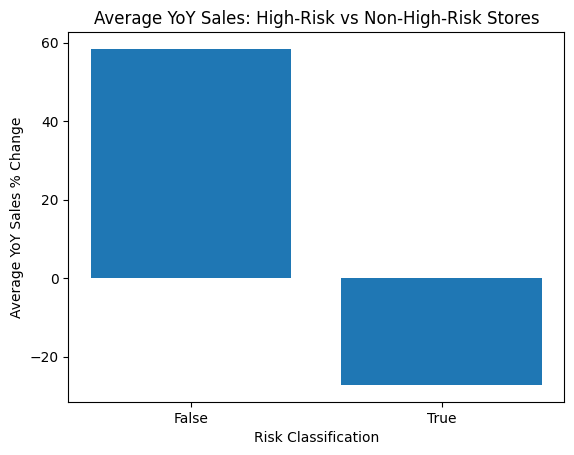

In [69]:
summary = (
    plot_df
    .groupby('likely_close_flag')['sales_pct_change']
    .mean()
    .reset_index()
)

plt.figure()
plt.bar(
    summary['likely_close_flag'].astype(str),
    summary['sales_pct_change']
)

plt.xlabel('Risk Classification')
plt.ylabel('Average YoY Sales % Change')
plt.title('Average YoY Sales: High-Risk vs Non-High-Risk Stores')
plt.show()

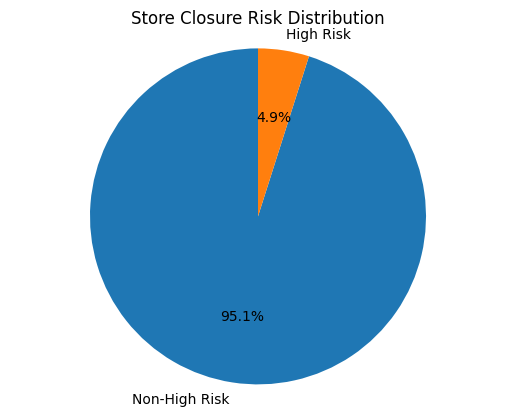

In [70]:
# One row per store (use max risk flag across years)
store_risk = (
    yearly_sales_final
    .groupby('location_id')['likely_close_flag']
    .max()
    .value_counts()
)

labels = ['Non-High Risk', 'High Risk']
sizes = [
    store_risk.get(False, 0),
    store_risk.get(True, 0)
]

plt.figure()
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Store Closure Risk Distribution')
plt.axis('equal')  # Makes it a circle
plt.show()

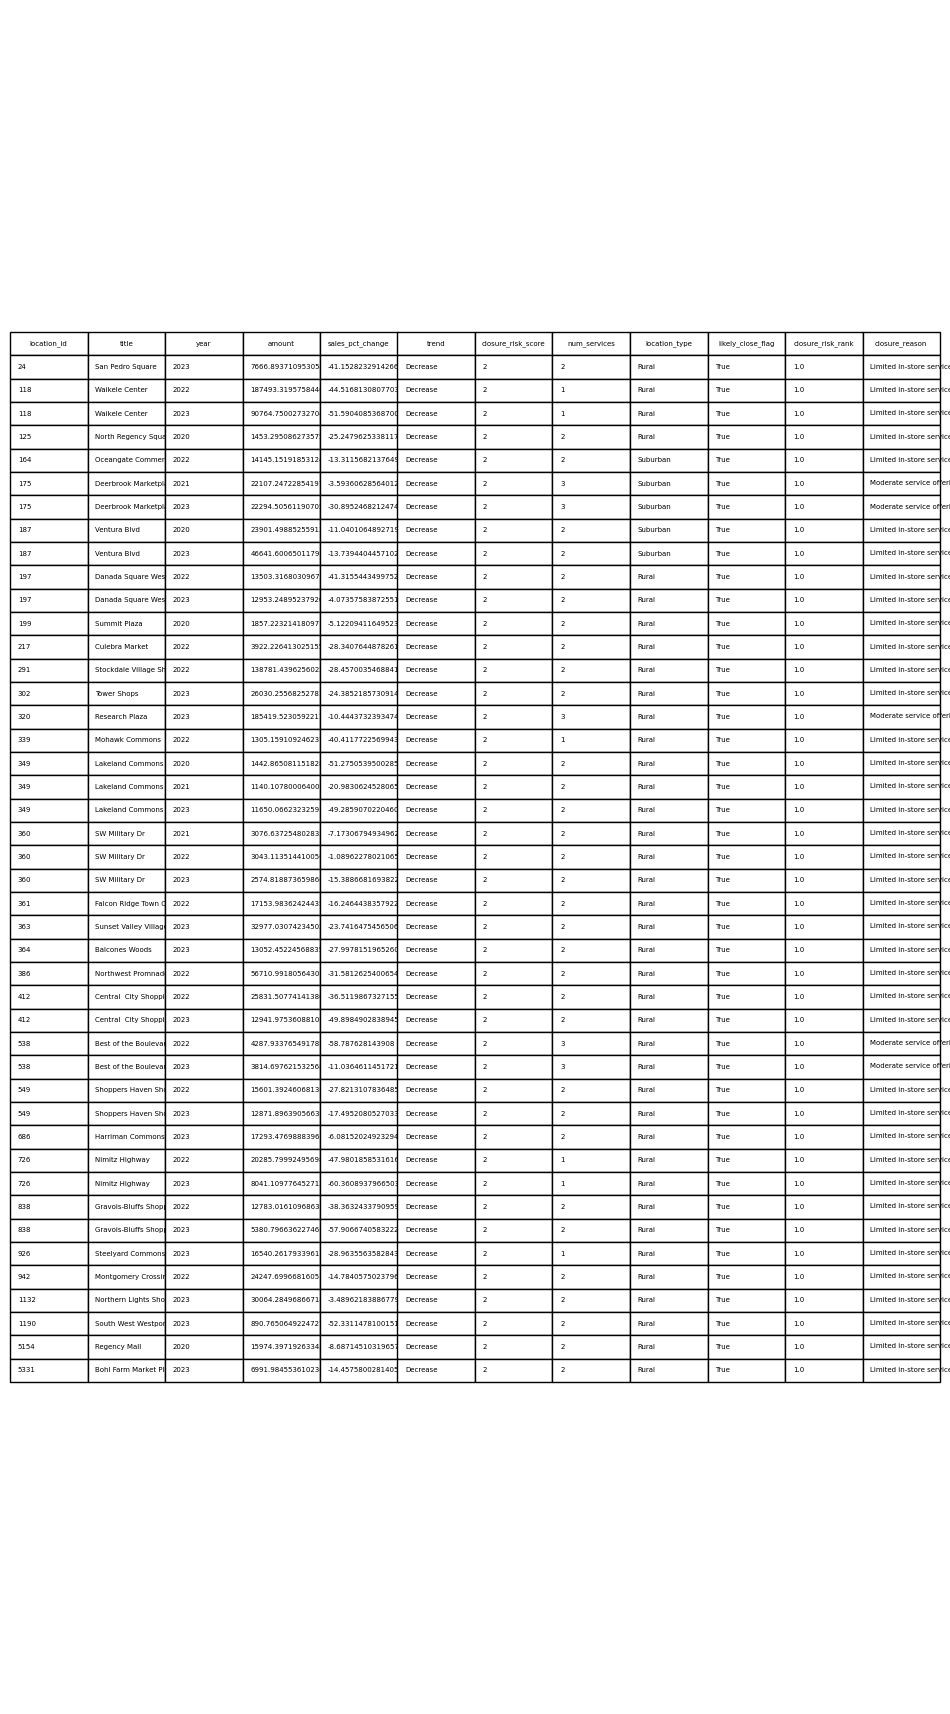

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 0.5 * len(likely_to_close)))
ax.axis("off")

table = ax.table(
    cellText=likely_to_close.values,
    colLabels=likely_to_close.columns,
    loc="center",
    cellLoc="left"
)

table.auto_set_font_size(False)
table.set_fontsize(5)
table.scale(1, 1.4)

plt.savefig("party_city_likely_store_closures.png", bbox_inches="tight")
plt.show()